## Caloric Suitability Index

This measure estimates "the potential (rather than actual) ... caloric yield per hectare per year, under low level of inputs and rain-fed agriculture, capturing cultivation methods that characterized early stages of development, while removing potential concerns that caloric yields.. Moreover, the estimates are based on agro-climatic constraints that are largely orthogonal to human intervention, mitigating further possible endogeneity." 
concerns.

> Galor, Oded, and Ömer Özak. 2016. “The Agricultural Origins of Time Preference.” American Economic Review 106 (10): 3064–103. https://doi.org/10.1257/aer.20150020.


Each cell is of size 5′ × 5′ (approximately 100 km2) across the globe.

Data at https://github.com/ozak/Caloric-Suitability-Index

In [10]:
import geopandas as gpd
import zipfile
import os
import requests
import rasterio
from rasterstats import zonal_stats

## Load data

### County border shapefile

We use the 2010 county boundary shapefile from the U.S. Census Bureau, because the historical population data that we use have been calculated using these boundaries.

We got these boundaries from the [Census Carto boundary files site](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2010.html#list-tab-1556094155)

The direct link to the file is: https://www2.census.gov/geo/tiger/GENZ2010/gz_2010_us_050_00_500k.zip


In [ ]:

import os

# Create map_data directory if it doesn't exist
os.makedirs('map_data', exist_ok=True)

# Download the 2010 county shapefile
url = "https://www2.census.gov/geo/tiger/GENZ2010/gz_2010_us_050_00_500k.zip"
filename = "map_data/gz_2010_us_050_00_500k.zip"

# Check if file already exists
if os.path.exists(filename):
    print(f"File {filename} already exists. Skipping download.")
    print(f"File size: {os.path.getsize(filename)} bytes")
else:
    print("Downloading 2010 county shapefile...")
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes

    with open(filename, 'wb') as f:
        f.write(response.content)

    print(f"File downloaded successfully to {filename}")
    print(f"File size: {os.path.getsize(filename)} bytes")

File map_data/gz_2010_us_050_00_500k.zip already exists. Skipping download.
File size: 8990289 bytes


In [16]:
#zip_path = 'map_data/cb_2024_us_county_20m.zip'
#zip_path = 'map_data/tl_2010_us_county10.zip'
zip_path = 'map_data/gz_2010_us_050_00_500k.zip'
extract_dir = 'map_data/temp'

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# List files in the extracted directory to verify shapefile name
print('Extracted files:', os.listdir(extract_dir))

# Find the .shp file in the extracted directory
shp_files = [f for f in os.listdir(extract_dir) if f.endswith('.shp')]
if shp_files:
    shapefile_path = os.path.join(extract_dir, shp_files[0])
    gdf = gpd.read_file(shapefile_path)
    # Exclude Alaska (02), Hawaii (15), and Puerto Rico (72) using STATEFP column
    exclude_fips = ['02', '15', '72']
    gdf = gdf[~gdf['STATE'].isin(exclude_fips)]
    gdf['GEOID'] = gdf['GEO_ID'].str.split('US').str[1]
    print(gdf.head(2))
else:
    print('No .shp file found in extracted directory.')

Extracted files: ['gz_2010_us_050_00_500k.dbf', 'gz_2010_us_050_00_500k.prj', 'gz_2010_us_050_00_500k.shp', 'gz_2010_us_050_00_500k.shx', 'gz_2010_us_050_00_500k.xml']
           GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  0500000US01029    01    029  Cleburne  County     560.100   
1  0500000US01031    01    031    Coffee  County     678.972   

                                            geometry  GEOID  
0  POLYGON ((-85.38872 33.91304, -85.38088 33.873...  01029  
1  POLYGON ((-86.03044 31.61894, -86.00408 31.619...  01031  


In [17]:
# Define the path to your raster data
raster_path = "data/caloric/post1500AverageCalories0.tif"

with rasterio.open(raster_path) as src:
    raster_crs = src.crs

In [18]:
gdf = gdf.to_crs(raster_crs)

In [19]:
# Calculate the mean value of the raster for each county
# This returns a list of dictionaries, one for each county
stats = zonal_stats(gdf, 
                    raster_path,
                    stats="mean min max median", # Specify stats you want
                    geojson_out=True) # Makes it easy to merge back

In [20]:
# Convert the results to a new GeoDataFrame
stats_gdf = gpd.GeoDataFrame.from_features(stats)

# You can now see columns like 'mean', 'min', 'max' in this GeoDataFrame
stats_gdf.head(2)


,geometry,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,min,max,mean,median
0,"POLYGON ((-85.38872 33.91304, -85.38089 33.873...",0500000US01029,01,029,Cleburne,County,560.100,01029,4725.311035,4954.967773,4863.006641,4904.264648
1,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",0500000US01031,01,031,Coffee,County,678.972,01031,4584.285645,4679.385742,4635.083750,4631.709961


In [23]:
# Select the columns you want to save
columns_to_save = ['STATE', 'GEOID', 'COUNTY', 'NAME', 'CENSUSAREA', 'min', 'max', 'mean', 'median']

# Create a DataFrame with only the selected columns (drop geometry for CSV)
csv_data = stats_gdf[columns_to_save].copy()

# Save to CSV
csv_data.to_csv('data/caloric/county_caloric_suitability.csv', index=False)

print(f"CSV file saved with {len(csv_data)} counties")
print(f"Columns: {list(csv_data.columns)}")
csv_data.head(2)

CSV file saved with 3109 counties
Columns: ['STATE', 'GEOID', 'COUNTY', 'NAME', 'CENSUSAREA', 'min', 'max', 'mean', 'median']


,STATE,GEOID,COUNTY,NAME,CENSUSAREA,min,max,mean,median
0,01,01029,029,Cleburne,560.100,4725.311035,4954.967773,4863.006641,4904.264648
1,01,01031,031,Coffee,678.972,4584.285645,4679.385742,4635.083750,4631.709961


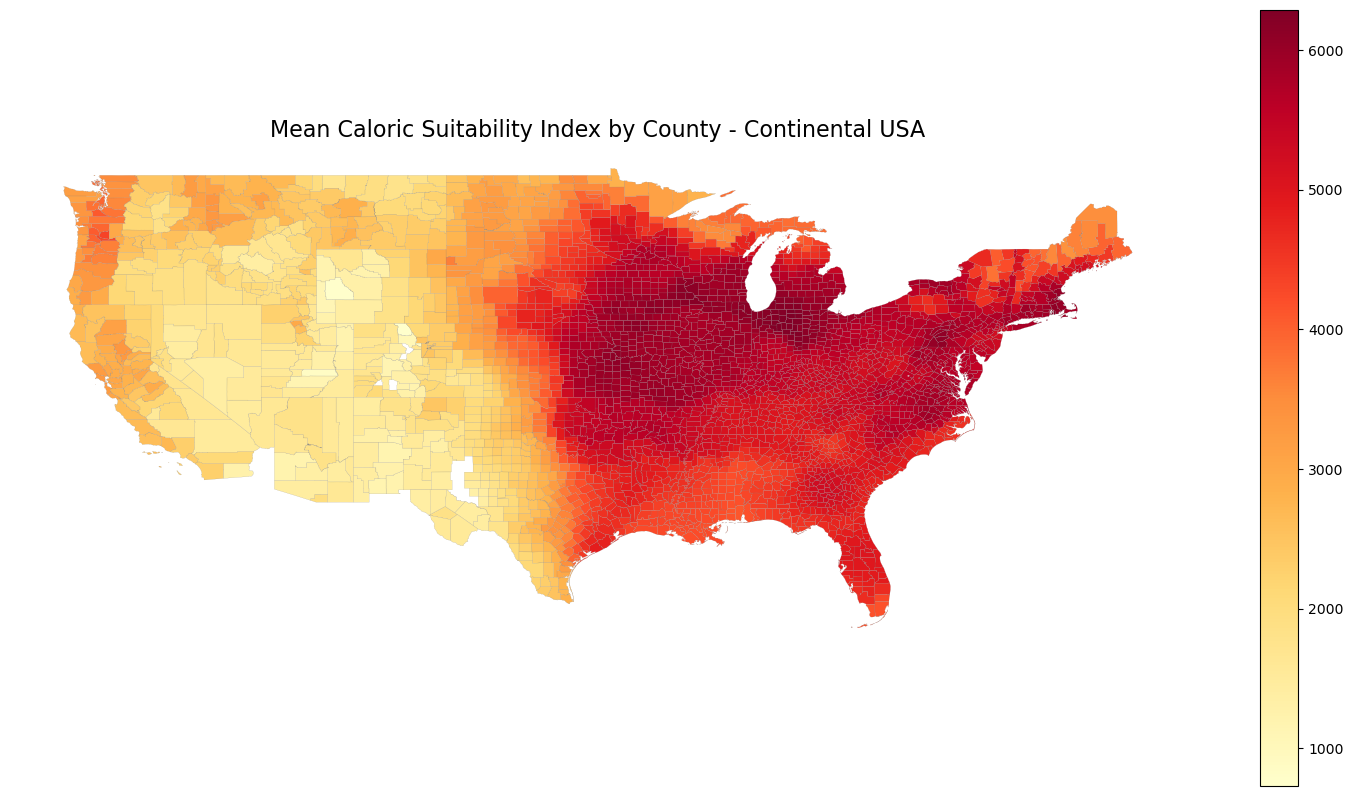

In [24]:
import matplotlib.pyplot as plt

# Create a choropleth map of mean caloric suitability
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the counties shaded by mean caloric suitability
stats_gdf.plot(
    column='mean',
    cmap='YlOrRd',
    linewidth=0.1,
    ax=ax,
    edgecolor='gray',
    legend=True,
    legend_kwds={'shrink': 0.8}
)

ax.set_title('Mean Caloric Suitability Index by County - Continental USA', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()